In [226]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from os.path import join
import os
import xarray as xr

import crime_patterns.utilities as utils
import crime_patterns.config as config
import crime_patterns.data_management as dm

from crime_patterns.final import plotting
from crime_patterns.analysis import point_patterns 
from crime_patterns.analysis import spatial_regression

from pysal.viz import splot
from splot.esda import plot_moran

from pysal.explore import esda
from pysal.lib import weights
import libpysal
from libpysal.weights import Queen, Rook, KNN
from pysal.model import spreg

from libpysal  import weights
from libpysal.weights import Queen
from spreg import OLS
from spreg import MoranRes
from spreg import ML_Lag
from spreg import ML_Error

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
src = config.SRC
bld = config.BLD
data_raw = src / "data"
data_clean = bld / "python" / "data"
results_dir = bld / "python" / "results" 
plots_dir = bld / "python" / "figures"

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

if not os.path.isdir(plots_dir):
    os.makedirs(plots_dir)

In [3]:
## define paths
shapefiles_dir = os.path.join(data_raw, "statistical-gis-boundaries-london", "statistical-gis-boundaries-london", "ESRI")
london_ward_shp_path = os.path.join(shapefiles_dir, "London_Ward.shp")
london_borough_shp_path = os.path.join(shapefiles_dir, "London_Borough_Excluding_MHW.shp")
london_lsoa_shp_path = os.path.join(shapefiles_dir, "LSOA_2011_London_gen_MHW.shp")
london_greater_area_shp_path = os.path.join(data_clean,  "Greater_London_Area.shp")

crime_incidences_path = os.path.join(data_clean, r"city-of-london-burglaries-2019-cleaned.csv") 
imd_ward_shp_path = os.path.join(data_clean, r"IMD_Ward_2019.shp")
imd_lsoa_shp_path = os.path.join(data_clean, r"IMD_LSOA_2019.shp")
burglary_ward_shp_path = os.path.join(data_clean, r"MPS_Ward_Level_burglary_2019.shp")

In [4]:
london_lsoa = gpd.read_file(london_lsoa_shp_path)
london_ward = gpd.read_file(london_ward_shp_path)
london_borough = gpd.read_file(london_borough_shp_path)
london_greater_area = gpd.read_file(london_greater_area_shp_path)

In [5]:
imd_ward = gpd.read_file(imd_ward_shp_path)
imd_lsoa = gpd.read_file(imd_lsoa_shp_path)
burglary_ward = gpd.read_file(burglary_ward_shp_path)

In [6]:
lsoa_total_pop = dm.aggregate_regional_level_data(
                                                lower_level_gdf = imd_lsoa,
                                                upper_level_gdf = london_ward,
                                                ID_column_name = "GSS_CODE",
                                                crs = config.CRS,
                                                )[["GSS_CODE", "TotPop", "geometry"]]

C:\Users\Mumu\Desktop\Bonn Econ\Winter22-23\EPP\crime_patterns\src\crime_patterns\data_management\clean_data.py:141: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_gdf = agg_gdf_groups.sum()


In [8]:
# Setup figure and axis
height = 8
width = height*0.75

Text(0.5, 1.0, 'IMD Score by LSOA')

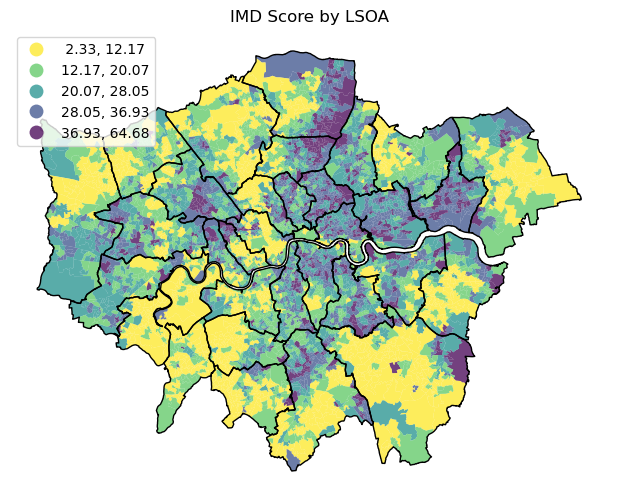

In [39]:
choropleth_kwds = {"scheme": "natural_breaks", "cmap": "viridis_r"}

fig, ax = plotting.plot_choropleth_map(region=imd_lsoa, column_name="IMDScore", figsize=(height, width), choropleth_kwds = choropleth_kwds)

london_borough.to_crs(imd_lsoa.crs).plot(ax=ax, fc="None")

ax.set_axis_off()
ax.set_title("IMD Score by LSOA")

c:\Users\Mumu\miniconda3\envs\crime_patterns\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Text(0.5, 1.0, 'IMD Score by Ward')

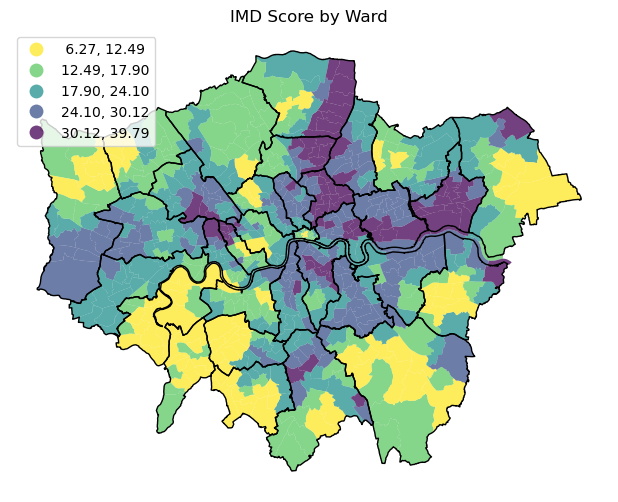

In [41]:
choropleth_kwds = {"scheme": "natural_breaks", "cmap": "viridis_r"}

fig, ax = plotting.plot_choropleth_map(region=imd_ward, column_name="IMDScore", figsize=(height, width), choropleth_kwds = choropleth_kwds)

london_borough.to_crs(imd_ward.crs).plot(ax=ax, fc="None")

ax.set_axis_off()
ax.set_title("IMD Score by Ward")

c:\Users\Mumu\miniconda3\envs\crime_patterns\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Text(0.5, 1.0, 'No. of Burglaries by Ward')

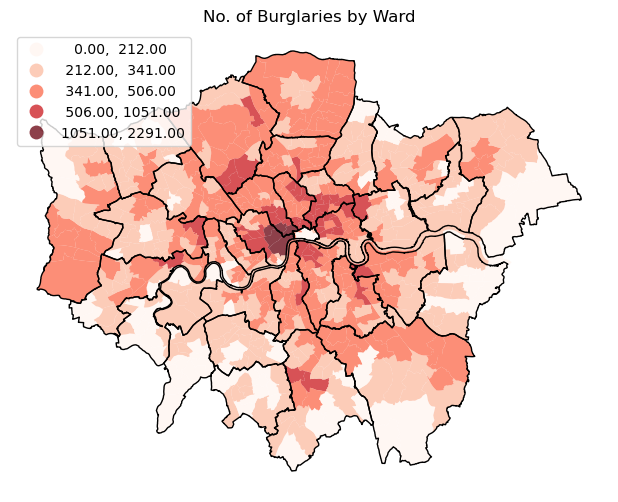

In [40]:
choropleth_kwds = {"scheme": "natural_breaks", "cmap": "Reds"}

fig, ax = plotting.plot_choropleth_map(region=burglary_ward, column_name="2019_total", figsize=(height, width), choropleth_kwds = choropleth_kwds)

london_borough.to_crs(burglary_ward.crs).plot(ax=ax, fc="None")

ax.set_axis_off()
ax.set_title("No. of Burglaries by Ward")

In [59]:
def prepare_data_for_spatial_regression(crime_data, explanatory_data, population, crime_col_name, population_col_name, ID_col_name, standardize=True):

    db = crime_data[[ID_col_name, crime_col_name]].merge(explanatory_data.drop("geometry", axis=1), on=ID_col_name)
    db = db.merge(population[[ID_col_name, population_col_name]], on=ID_col_name)
    db[f"{crime_col_name}_rate"] = db[crime_col_name] / db[population_col_name]

    if standardize:
        db_num = db.select_dtypes(include='number')
        db_num = (db_num - db_num.mean()) / db_num.std()
        db[db_num.columns] = db_num

    # introduce "geometry" column
    db = db.merge(explanatory_data[["GSS_CODE", "geometry"]], on="GSS_CODE")

    return db 

# db = burglary_ward[["GSS_CODE", '2019_total']].merge(imd_ward.drop("geometry", axis=1), on="GSS_CODE")
# db["TotPop"] = lsoa_total_pop["TotPop"]
# db["burglary_rate"] = db["2019_total"] / db["TotPop"]
# standardized_db = (db - db.mean()) / db.std()

In [178]:
db = prepare_data_for_spatial_regression(crime_data=burglary_ward, explanatory_data=imd_ward, population=lsoa_total_pop, crime_col_name="2019_total", population_col_name="TotPop", ID_col_name="GSS_CODE", standardize=True)

In [179]:
db = db.rename(columns={"2019_total_rate": "burglary_rate_2019"})

In [180]:
dependent_variable_name = 'burglary_rate_2019'
independent_variable_names = ['IncScore', 'EmpScore', 'EnvScore', 'BHSScore', 'EduScore'] # 'IMDScore', 'BHSScore', 'EduScore', 'EduScore','IncScore', 'EmpScore', 'EnvScore', 'BHSScore', 'EduScore'

In [197]:
nonspatial_model = spatial_regression.perform_non_spatial_regression(db, dependent_variable_name, independent_variable_names)

In [199]:
print(nonspatial_model.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :burglary_rate_2019                Number of Observations:         649
Mean dependent var  :      0.0000                Number of Variables   :           6
S.D. dependent var  :      1.0000                Degrees of Freedom    :         643
R-squared           :      0.2398
Adjusted R-squared  :      0.2338
Sum squared residual:     492.635                F-statistic           :     40.5573
Sigma-square        :       0.766                Prob(F-statistic)     :   2.762e-36
S.E. of regression  :       0.875                Log likelihood        :    -831.438
Sigma-square ML     :       0.759                Akaike info criterion :    1674.876
S.E of regression ML:      0.8712                Schwarz criterion     :    1701.729

-----------------------------------------------------------------------

In [210]:
model_ols = spatial_regression.perform_spatial_regression(db, dependent_variable_name, independent_variable_names, method="OLS")

In [211]:
print(model_ols.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :Burglary_VS_IMDScores
Weights matrix      :           W
Dependent Variable  :burglary_rate_2019                Number of Observations:         649
Mean dependent var  :      0.0000                Number of Variables   :           6
S.D. dependent var  :      1.0000                Degrees of Freedom    :         643
R-squared           :      0.2398
Adjusted R-squared  :      0.2338
Sum squared residual:     492.635                F-statistic           :     40.5573
Sigma-square        :       0.766                Prob(F-statistic)     :   2.762e-36
S.E. of regression  :       0.875                Log likelihood        :    -831.438
Sigma-square ML     :       0.759                Akaike info criterion :    1674.876
S.E of regression ML:      0.8712                Schwarz criterion     :    1701.729

--------------------------------------------------------------

In [212]:
model_ml_lag = spatial_regression.perform_spatial_regression(db, dependent_variable_name, independent_variable_names, method="ML_Lag")
print(model_ml_lag.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :Burglary_VS_IMDScores
Weights matrix      :           W
Dependent Variable  :burglary_rate_2019                Number of Observations:         649
Mean dependent var  :      0.0000                Number of Variables   :           7
S.D. dependent var  :      1.0000                Degrees of Freedom    :         642
Pseudo R-squared    :      0.6227
Spatial Pseudo R-squared:  0.1310
Sigma-square ML     :       0.392                Log likelihood        :    -658.780
S.E of regression   :       0.626                Akaike info criterion :    1331.561
                                                 Schwarz criterion     :    1362.889

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
--------------

c:\Users\Mumu\miniconda3\envs\crime_patterns\Lib\site-packages\scipy\optimize\_minimize.py:892: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


In [213]:
model_ml_error = spatial_regression.perform_spatial_regression(db, dependent_variable_name, independent_variable_names, method="ML_Error")
print(model_ml_error.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL ERROR (METHOD = FULL)
-------------------------------------------------------------------
Data set            :Burglary_VS_IMDScores
Weights matrix      :           W
Dependent Variable  :burglary_rate_2019                Number of Observations:         649
Mean dependent var  :      0.0000                Number of Variables   :           6
S.D. dependent var  :      1.0000                Degrees of Freedom    :         643
Pseudo R-squared    :      0.2315
Sigma-square ML     :       0.367                Log likelihood        :    -640.605
S.E of regression   :       0.606                Akaike info criterion :    1293.211
                                                 Schwarz criterion     :    1320.064

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
--------------------------------------------

c:\Users\Mumu\miniconda3\envs\crime_patterns\Lib\site-packages\scipy\optimize\_minimize.py:892: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


In [214]:
spatial_regression.get_reg_summary(model_ols)

,Independent Variable,Std. Error,t-Statistic,Probabilty,Dependent Variable
0,CONSTANT,0.034359,1.452548e-14,1.000000e+00,burglary_rate_2019
1,IncScore,0.171565,1.339414e-01,8.934908e-01,burglary_rate_2019
2,EmpScore,0.162381,1.132993e+00,2.576395e-01,burglary_rate_2019
3,EnvScore,0.041478,1.056868e+01,3.504702e-24,burglary_rate_2019
4,BHSScore,0.044677,-6.905395e+00,1.204680e-11,burglary_rate_2019
5,EduScore,0.057166,-3.722488e-01,7.098303e-01,burglary_rate_2019


In [216]:
model_ml_error.z_stat

[(2.2743262482987854, 0.02294637811580476),
 (0.38803017142289536, 0.6979937059489473),
 (0.3403960982479633, 0.7335582566006116),
 (9.375658797877572, 6.874509933233292e-21),
 (-5.818735907556192, 5.929433067079747e-09),
 (-0.0816505275498441, 0.9349246202243396),
 (36.646114374574125, 5.276832183719486e-294)]

In [224]:
spatial_regression.get_reg_summary(model_ml_error, method="ML_Error")

,Independent Variable,Std. Error,z-Statistic,Probabilty,Dependent Variable
0,CONSTANT,0.185592,2.274326,2.294638e-02,burglary_rate_2019
1,IncScore,0.214480,0.388030,6.979937e-01,burglary_rate_2019
2,EmpScore,0.193861,0.340396,7.335583e-01,burglary_rate_2019
3,EnvScore,0.070663,9.375659,6.874510e-21,burglary_rate_2019
4,BHSScore,0.065124,-5.818736,5.929433e-09,burglary_rate_2019
5,EduScore,0.075369,-0.081651,9.349246e-01,burglary_rate_2019
6,lambda,0.023767,36.646114,5.276832e-294,burglary_rate_2019


In [225]:
spatial_regression.get_reg_summary(model_ml_error, method="ML_Lag")

,Independent Variable,Std. Error,z-Statistic,Probabilty,Dependent Variable
0,CONSTANT,0.185592,2.274326,2.294638e-02,burglary_rate_2019
1,IncScore,0.214480,0.388030,6.979937e-01,burglary_rate_2019
2,EmpScore,0.193861,0.340396,7.335583e-01,burglary_rate_2019
3,EnvScore,0.070663,9.375659,6.874510e-21,burglary_rate_2019
4,BHSScore,0.065124,-5.818736,5.929433e-09,burglary_rate_2019
5,EduScore,0.075369,-0.081651,9.349246e-01,burglary_rate_2019
6,lambda,0.023767,36.646114,5.276832e-294,burglary_rate_2019


In [227]:
spatial_regression.get_spatial_diagnostics(model_ols)

,Lagrange Multiplier (error),Lagrange Multiplier (lag),Robust LM (error),Robust LM (lag),Moran's I
Value,5.751404e+02,4.978939e+02,7.976367e+01,2.517160,4.519589e-01
p-value,4.277110e-127,2.730356e-110,4.219811e-19,0.112613,2.704057e-138
